## Gravitational wave Astrometry estimates for an isolated CW source

This notebook build on the `MetricsNotebook` to compute an estimate for the precision with which the sky location of an isolated monochromatic gravitatioal wave source can be measured with a specific space-based GW mission concept. 

To run this on Google Colab:
markdown
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/CWSNRNotebook.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
    !mkdir -p '../plots/'else:
    src='../src/'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background

### Define the source
Here we load in one of our pre-defined sources


In [2]:
sourceName = 'AmCV'
source = eval('sources.%s' % sourceName).copy()
source

{'type': 'CW',
 'label': 'AmCV',
 'm1': 0.68,
 'm2': 0.125,
 'dl': 0.3,
 'a': 0.000475}

### Define the mission concept
Here we load in one or more mission concepts from our pre-defined list. You could also define your own

In [3]:
# list of concepts by name
conceptNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA')

models = list()
for c in conceptNames:
    model = eval('concepts.%s' % c)         # load the concept
    model = background.add2model(model)     # add galactic background model
    models.append(model)                    # add model to list
    

### Perform the observations
First we do the SNR calculaiton, then the angular resolution

In [4]:
obs = list()
for m in models:
    ob = metrics.getSourceSnr(source,m,4.0*constants.year)
    ob = metrics.getResolution(ob)
    obs.append(ob)
    

### Plots

#### Sensitivity curves


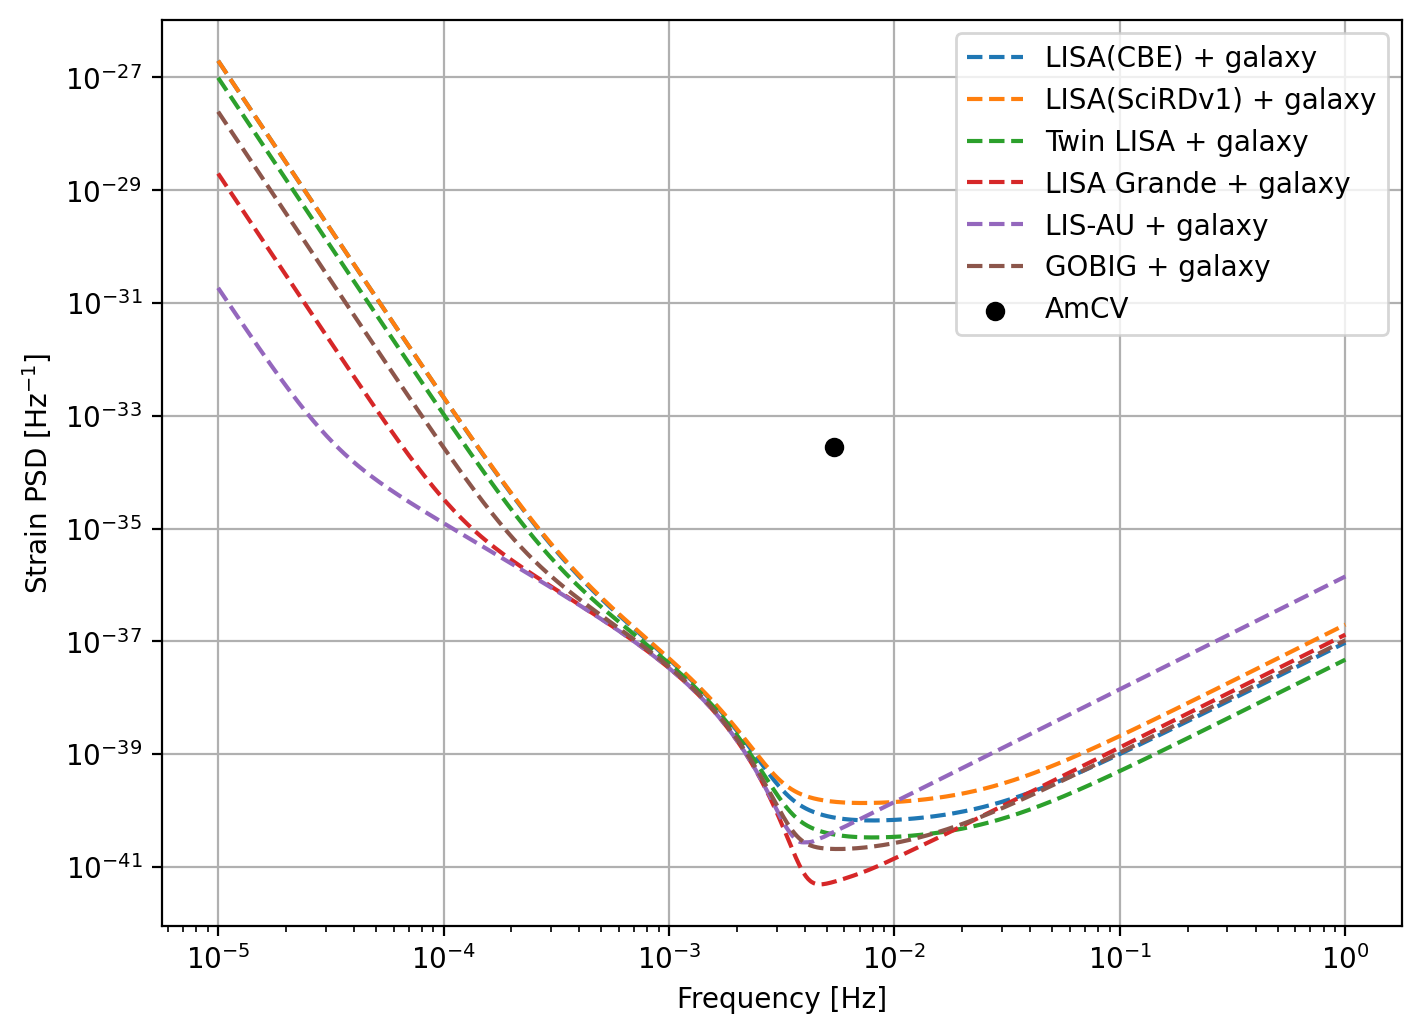

In [5]:
# sensitivity plot
fig = plt.figure(figsize=(8,6),dpi=200)
ax = fig.add_subplot(1,1,1)
f = np.logspace(-5,0,1000)
for ob in obs:
    ax.plot(f,metrics.makeSensitivity(f,ob.get('model')),linestyle='--',label=ob.get('model').get('label'))
    
hc = 10*((2./5.*ob.get('h'))**2)*ob.get('t')[-1]    
ax.scatter(ob.get('f'),hc,color='black',label=ob.get('source').get('label'))

ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_sensitivities.png' % sourceName)

#### SNR as a funciton of time plot

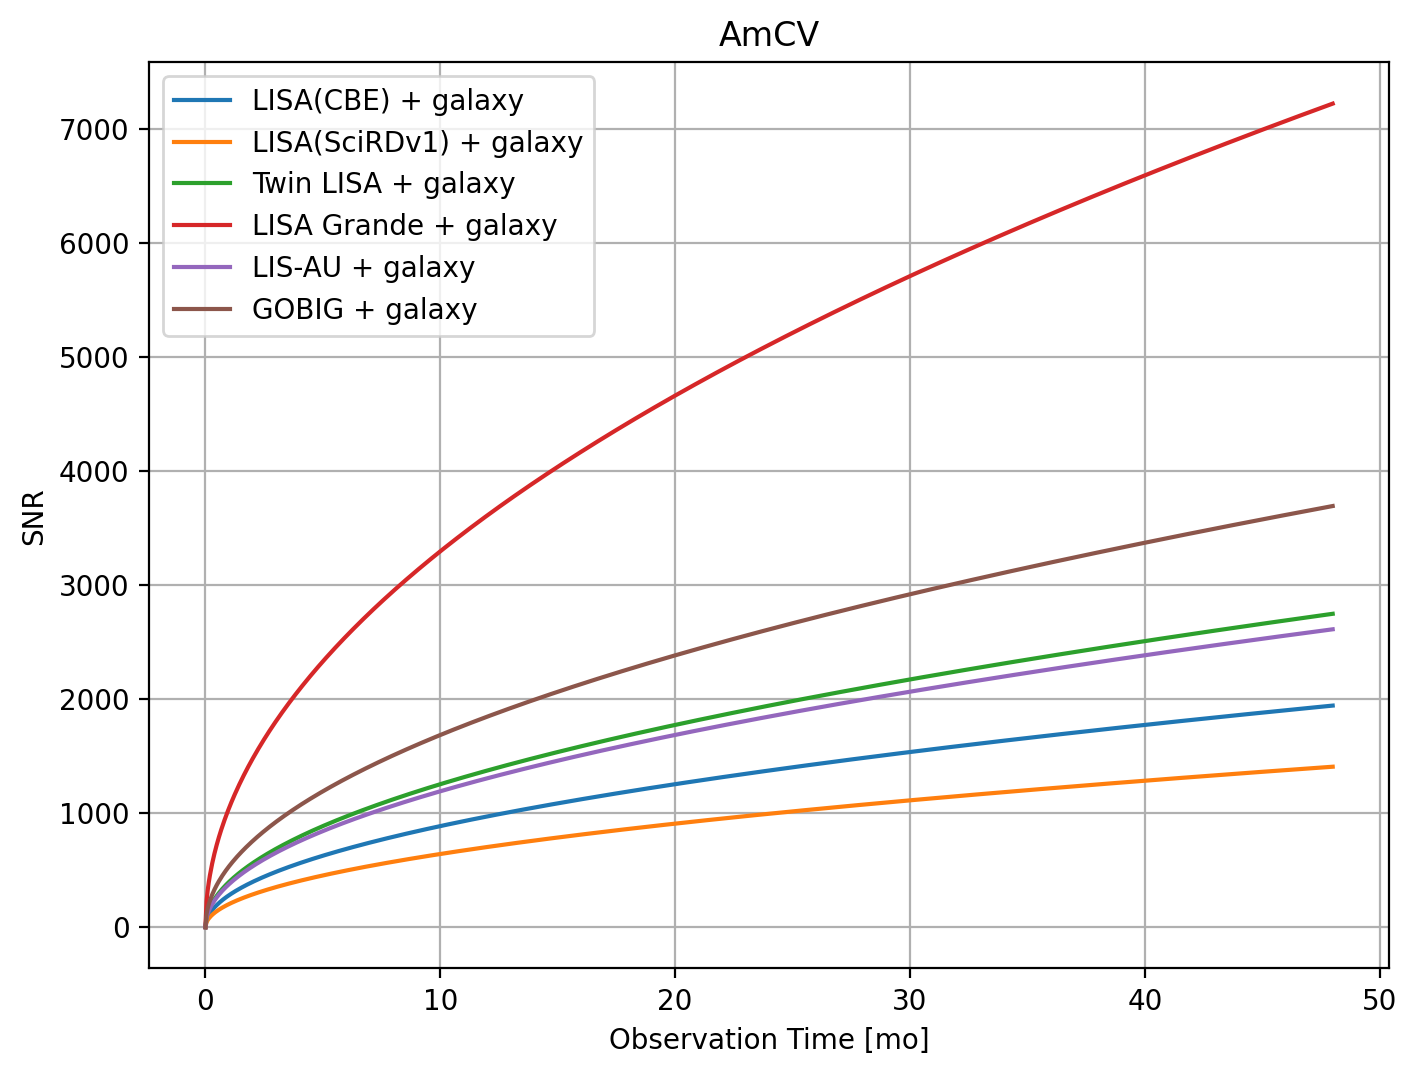

In [6]:
# SNR of time plot
fig = plt.figure(figsize=(8,6),dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(ob.get('t')*12/constants.year,ob.get('SNR of t'),linestyle='-',label=ob.get('model').get('label'))

plt.title(ob.get('source').get('label'))
ax.set_xscale('linear')
ax.set_yscale('linear')
plt.xlabel('Observation Time [mo]')
plt.ylabel(r'SNR')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_snr_v_t.png' % sourceName)

### Angular resolution

First we estimate the diffraction-liied angular resolution as a function of observation time from

$\delta\theta \approx \lambda_{GW}/B$

where $\lambda_{GW} = c/f_{GW}$ is the GW frequency and B is the observation baseline

for a ciruclar orbit:

$B=R_{orbit}\sqrt{2(1-cos[2\pi t/T_{orbit}])}$


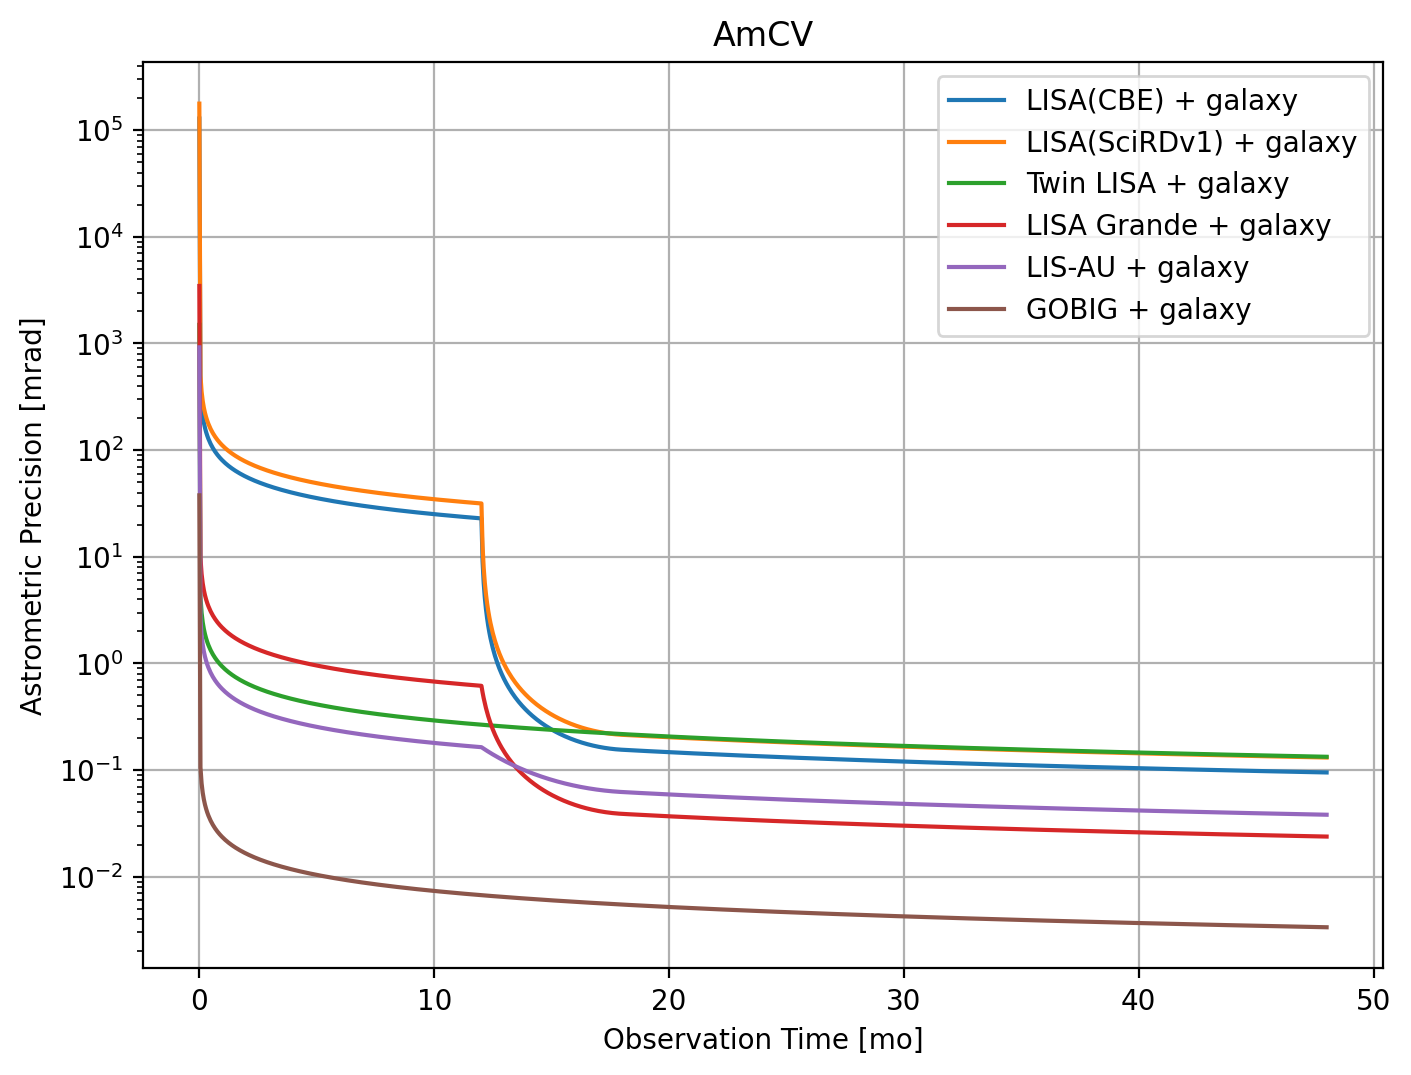

In [7]:
# Angular resolution
fig = plt.figure(figsize=[8,6],dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(ob.get('t')*12/constants.year,ob.get('Angular Resolution')*1e3,label= ob.get('model').get('label'))

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.xlabel('Observation Time [mo]')
plt.ylabel('Astrometric Precision [mrad]')
plt.title(ob.get('source').get('label'))
plt.savefig('../plots/%s_res_v_t.png' % sourceName)

### Make a table of the results

In [8]:
import pandas as pd

In [15]:
t_table = 2.0*constants.year
t = obs[0].get('t')
i_table = np.clip(np.argmin(np.abs(t-t_table)),0,np.size(t)-1)
names = list()
SNRs = list()
res = list()
obtimes = list()
for ob in obs:
    names.append(ob.get('model').get('label'))
    SNRs.append(ob.get('SNR of t')[i_table])
    res.append(ob.get('Angular Resolution')[i_table]/1e-3)

df = pd.DataFrame(index = names, data = {
    'SNR' : SNRs,
    'Angular Resolution [mrad]' : res,
})

df['Angular Resolution [arcsec]']= df['Angular Resolution [mrad]']*1e-3*180/np.pi*3600
df[['SNR', 'Angular Resolution [mrad]', 'Angular Resolution [arcsec]']]
    

,SNR,Angular Resolution [mrad],Angular Resolution [arcsec]
LISA(CBE) + galaxy,1374.285162,0.134251,27.691301
LISA(SciRDv1) + galaxy,995.355607,0.185360,38.233315
Twin LISA + galaxy,1943.325539,0.188320,38.843710
LISA Grande + galaxy,5105.999914,0.033626,6.935876
LIS-AU + galaxy,1847.265674,0.053885,11.114660
GOBIG + galaxy,2611.387830,0.004744,0.978561
